# Задача

Во вложении sample.xlsx содержится таблица с данными по 5000 клиентов в следующей кодификации:                                                
No : Порядковый номер клиента                
predictor1-5* : Фичи (предикторы) по которым необходимо построить модель. Все переменные являются количественными.
Target : Целевая бинарная переменная, обозначающая факт дефолта клиента    
Задача: Необходимо построить модель, позволяющую предсказывать вероятность дефолта клиента. Предлагается построить 2 конкурирующие модели (например, логистическая регрессия и дерево решений) и произвести выбор наилучшей модели на основе предложенного вами показателя качества.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Загрузка данных

In [2]:
df = pd.read_excel('sample.xlsx', index_col='No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   predictor 1  10000 non-null  int64  
 1   predictor 2  10000 non-null  int64  
 2   predictor 3  8087 non-null   float64
 3   predictor 4  10000 non-null  int64  
 4   predictor 5  10000 non-null  float64
 5   target       10000 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 546.9 KB


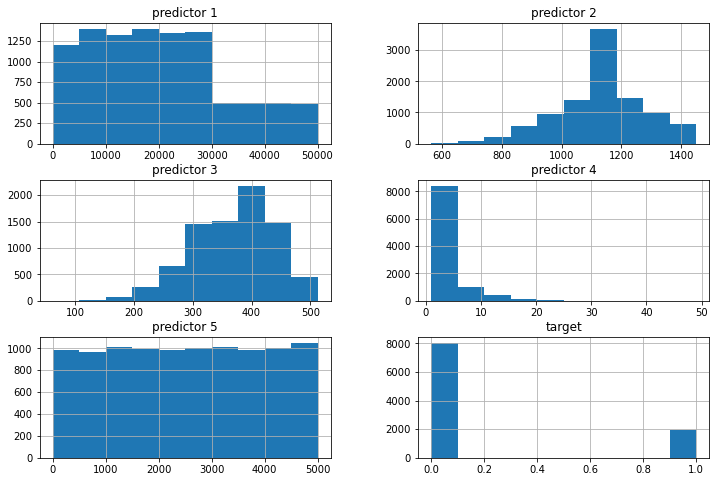

In [3]:
df.hist(figsize=(12, 8));

### Выбор показателей качества
Так как нас больше всего интересуют обнаруженные моделью дефолты (true positive), то Recall будет хорошим показателем. Применять его будем в комбинации с Precision, чтобы понимать, как много ошибочных дефолтов модель прогнозирует.

Так как у меня нет информации о том, какой баланс Precision/Recall будет являеться оптимальным, то основной метрикой будет использована ROC AUC score. Её часто применяют в задачах, где положительный класс в меньшинстве.

Основная метрика: ROC AUC score. 
Дополнительные: Recall, Precision

In [4]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

metrics = [roc_auc_score, precision_score, recall_score]
METRICS_NAMES = ["Roc_AUC", "precision", "recall"]
scoring_metrics = {}
for metric_name, metric in zip(METRICS_NAMES, metrics):
    scoring_metrics[metric_name] = make_scorer(metric)

In [5]:
def display_scores(model, X, y, fit_params=None):
    """
    Takes (model, X, y) and after performing cross validation prints out metrics
    """
    print("Fitting model")
    scores = cross_validate(model, X, y, cv=5,
                    scoring=scoring_metrics,
                    return_train_score=True,
                    n_jobs=-1,
                    fit_params=fit_params)

    for step in ["test_", "train_"]:
        print("---------------")
        for metr_name in METRICS_NAMES:
            key = step + metr_name
            print("{} {} = {}".format(step[:-1], metr_name, scores[key].mean()))
    
    return scores

### Подготовка данных.

Мы можем увидеть, что в колонке с предиктором 3 имеются нулевые значения. Метод заполнения определим экспериментально.

Также имеется дисбаланс классов, но я не буду применять дополнительных методов (например взятия выборок) для его сокращения. Вместо этого мы будем добавлять вес к положительному классу в моделях.

Так как оценку во время экспериментов я буду проводить методом кросс валидации, разделим данные только на тренировочный и тест сеты.

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=99)
X_train.shape, X_test.shape

((8000, 5), (2000, 5))

In [7]:
X_train.head()

,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5
No,,,,,
7599,22308,1106,404.0,1,2844.0
7941,12179,1106,361.5,5,212.0
7608,314,1076,280.5,9,1020.0
6504,10493,1148,357.0,3,4609.0
8678,12034,916,434.0,3,804.0


Добавим пайплайн для препроцессинга. Модели будут использоваться в пайплайнах вместе с подготовкой данных, потому что это помогает избежать утечек целевой переменной и упрощает эксперименты с методами подготовки данных. К тому же, в данном случае данные обрабатываются быстро и постоянная "переподготовка" не будет значительно влиять на производительность.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

preproc_pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                               ('std_scaler', StandardScaler())])

### Логистическая регрессия

In [11]:
from sklearn.linear_model import LogisticRegression
LR_pipe = Pipeline([("preproc", preproc_pipe),
                 ("log_reg", LogisticRegression(class_weight={0:1,1:5}))])
LR_scores = display_scores(LR_pipe, X_train, y_train)

Fitting model
---------------
test Roc_AUC = 0.6503738257158871
test precision = 0.2920046303831616
test recall = 0.7320717621037109
---------------
train Roc_AUC = 0.6523511187129382
train precision = 0.2936042488841809
train recall = 0.7336952163508809


При балансе классов 1 к 5 мы имеем повышенный Recall. То есть модель обнаруживает до 73% клиентов с дефолтом. Правда ценой очень высокого показателя ложных прогнозов.

### RandomForest

Проверим RandomForest модель. Чтобы уменьшить оверфит модели, я подобрал параметр max_leaf_nodes перебором (около 3 попыток), более тщательный выбор параметров будет выполнен далее.

In [20]:
from sklearn.ensemble import RandomForestClassifier
RF_pipe = Pipeline([("preproc", preproc_pipe),
                 ("rand_for", RandomForestClassifier(max_leaf_nodes=180,
                                                     class_weight={0:1,1:7}))])
RF_scores = display_scores(RF_pipe, X_train, y_train)

Fitting model
---------------
test Roc_AUC = 0.6562165186991553
test precision = 0.31396372060655126
test recall = 0.6662263455394446
---------------
train Roc_AUC = 0.8212151802790364
train precision = 0.43202810173353584
train recall = 0.9440538304180937


Опираясь на test recall, мы можем сказать, что подобная модель корректно идентифицирует до 66% дефолтов. И у 32% указанных моделью клиентов (precision) действительно был дефолт.

In [21]:
RF_model = Pipeline([("preproc", preproc_pipe),
                 ("rand_for", RandomForestClassifier(n_estimators=500,
                                                     max_leaf_nodes=180,
                                                     class_weight={0:1,1:7}))])

RF_model.fit(X_train, y_train);

На тест сете показатель AUC выглядит немного лучше, то есть мы можем утверждать, что модель не имеет сильного оверфита. 

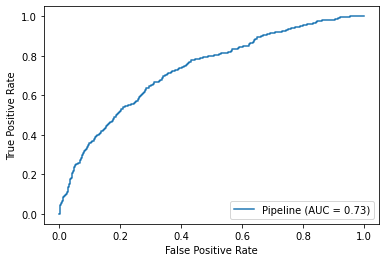

In [22]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(RF_model, X_test, y_test);

Модель, конечно, совершает много ошибок. Как и ожидалось, большинство ошибок в ложном определении дефолта клиента, это обусловлено регулировкой весов функции потерь модели.

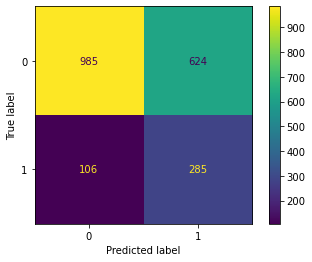

In [23]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RF_model, X_test, y_test);

Взглянем на вклад отдельных предикторов

Feature ranking:
1. feature 2 (0.297384)
2. feature 1 (0.284254)
3. feature 4 (0.165991)
4. feature 0 (0.160266)
5. feature 3 (0.092104)


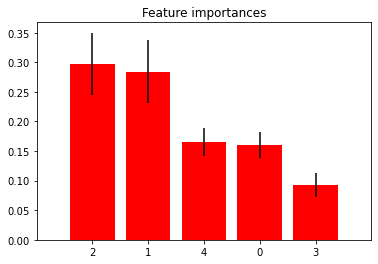

In [24]:
forest = RF_model["rand_for"]
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Похоже все данные участвуют в прогнозе.
Так как у меня нет никакой информации о данных, пытаться генерировать новые предикторы представляется затруднительным. 
Я попробовал применить PolynomialFeatures и SVM для увелечения размерности датасета, но в данном случае это не приносит положительных результатов.

### XGBoost
Далее используем XGBClassifier и применим к нему случайный поиск параметров.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, expon, randint
from xgboost import XGBClassifier

params = {
        'xgb__n_estimators': randint(50, 500),
        'xgb__min_child_weight': randint(2, 10),
        'xgb__gamma':  expon(scale=.1),
        'xgb__subsample': uniform(0.4, 0.5),
        'xgb__colsample_bytree': uniform(0.3, 0.7),
        'xgb__max_depth': randint(4, 12),
        'preproc__imputer__strategy': ['constant', 'mean', 'median']
        }
xgb = Pipeline([("preproc", preproc_pipe),
                ("xgb", XGBClassifier(learning_rate=0.02, 
                                      objective='binary:logistic',
                                      silent=True, 
                                      scale_pos_weight=5))])

param_comb = 100

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc', 
                                   n_jobs=4, 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=99)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(fill_value=0,
                                                                             strategy='constant')),
                                                              ('std_scaler',
                                                               StandardScaler())])),
                                             ('xgb',
                                              XGBClassifier(learning_rate=0.02,
                                                            scale_pos_weight=5,
                                                            silent=True))]),
                   n_iter=100, n_jobs=4,
                   param_distributions={'preproc__imputer__strategy': ['constant',
                                                                       'mean'

In [26]:
xgb_y_pred = random_search.best_estimator_.predict(X_test)
xgb_y_score = random_search.best_estimator_.predict_proba(X_test)
print("Precision =", precision_score(y_test, xgb_y_pred))
print("Recall =", recall_score(y_test, xgb_y_pred))
print("ROC_AUC =", roc_auc_score(y_test, xgb_y_score[:,1]))

Precision = 0.3023255813953488
Recall = 0.7979539641943734
ROC_AUC = 0.7429818523999433


На тест сете мы получаем результаты лучше предыдущих.
Проведем поиск параметров и для RandomForest.

In [27]:
params = {
        'forest__n_estimators': randint(50, 500),
        'forest__max_leaf_nodes': randint(50, 200),
        'forest__max_depth': randint(3, 20),
        'forest__min_samples_split': randint(3, 20),
        'preproc__imputer__strategy': ['constant', 'mean', 'median']
        }

rfc = Pipeline([("preproc", preproc_pipe),
                 ("forest", RandomForestClassifier(class_weight={0:1,1:5}))])

param_comb = 100

random_search_f = RandomizedSearchCV(rfc, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc', 
                                   n_jobs=4, 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=99)

random_search_f.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer(fill_value=0,
                                                                             strategy='constant')),
                                                              ('std_scaler',
                                                               StandardScaler())])),
                                             ('forest',
                                              RandomForestClassifier(class_weight={0: 1,
                                                                                   1: 5}))]),
                   n_iter=100, n_jobs=4,
                   param_distributions={'forest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000...
                                        'forest__max_leaf_nodes': <scipy.stats._distn_

In [28]:
rnf_y_pred = random_search_f.best_estimator_.predict(X_test)
rnf_y_score = random_search_f.best_estimator_.predict_proba(X_test)
print("Precision =", precision_score(y_test, rnf_y_pred))
print("Recall =", recall_score(y_test, rnf_y_pred))
print("ROC_AUC =", roc_auc_score(y_test, rnf_y_score[:,1]))

Precision = 0.2984097287184284
Recall = 0.8158567774936062
ROC_AUC = 0.7402645604408705


### Ensemble

Объединим классификаторы в ансамбль.

In [76]:
from sklearn.ensemble import VotingClassifier

# Deleting unnecessary words from best parameters names
xgb_best_params = {k[5:]: v for (k, v) in random_search.best_params_.items() 
                           if not k.startswith('preproc')}
rnf_best_params = {k[8:]: v for (k, v) in random_search_f.best_params_.items() 
                           if not k.startswith('preproc')}


log_clf = LogisticRegression(class_weight={0:1,1:5})
rnf_clf = RandomForestClassifier(class_weight={0:1,1:5},**rnf_best_params)
xgb_clf = XGBClassifier(learning_rate=0.02, scale_pos_weight=5, **xgb_best_params)


voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('rnf', rnf_clf), 
                                          ('xgb', xgb_clf)],
                              voting='soft')

final_preproc_pipe = Pipeline([('imputer', SimpleImputer(strategy="median")),
                               ('std_scaler', StandardScaler())])

Vote_pipe = Pipeline([("preproc", final_preproc_pipe),
                 ("rand_for", voting_clf)])

Precision = 0.3031458531935176
Recall = 0.8132992327365729
ROC_AUC = 0.74516744844775


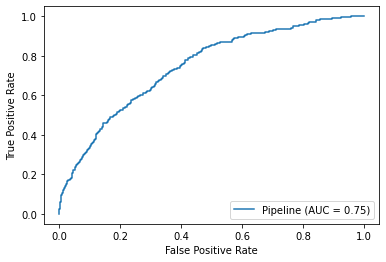

In [77]:
Vote_pipe.fit(X_train, y_train)

vote_y_pred = Vote_pipe.predict(X_test)
vote_y_score = Vote_pipe.predict_proba(X_test)
print("Precision =", precision_score(y_test, vote_y_pred))
print("Recall =", recall_score(y_test, vote_y_pred))
print("ROC_AUC =", roc_auc_score(y_test, vote_y_score[:,1]))

plot_roc_curve(Vote_pipe, X_test, y_test);

Похоже мы добились определенного прогресса по сравнению с начальными результатами без поиска параметров. Изобразим график полученных результатов.

In [100]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

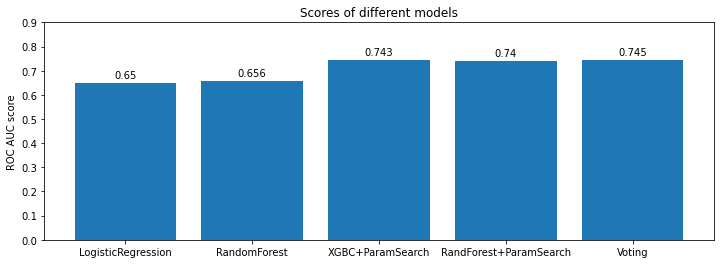

In [106]:
LR_auc = LR_scores['test_Roc_AUC'].mean()
RF_auc = RF_scores['test_Roc_AUC'].mean()
XGB_RS_auc = roc_auc_score(y_test, xgb_y_score[:,1])
RF_RS_auc = roc_auc_score(y_test, rnf_y_score[:,1])
Vote_auc = roc_auc_score(y_test, vote_y_score[:,1])

fig, ax = plt.subplots(figsize=(12,4))
rects = ax.bar(['LogisticRegression',
                'RandomForest',
                'XGBC+ParamSearch',
                'RandForest+ParamSearch',
                'Voting'], 
        [LR_auc, RF_auc, XGB_RS_auc, RF_RS_auc, Vote_auc])
autolabel(rects)
ax.set_ylabel('ROC AUC score')
ax.set_title('Scores of different models')
plt.ylim((0.0, 0.9));

### Выводы
Похожи наши данные имеют большое количество шума (случайности), что не дает моделям легко распознать признаки дефолта клиента. Но все же модель может корректно подсказывать, на каких клиентов следует обратить больше внимания. К тому же, в зависимости от наших целей, мы можем отредактировать баланс Precision/Recall.

Потенциальные улучшения: 
Провести более тщательный поиск параметров и увеличить количество моделей в ансамбле. 
Создать модель, которая на основании прогнозов моделей из ансамбля, будет выдавать итоговый прогноз.